# Compare results with Gillen et al.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import mplhep as hep
from iminuit import Minuit
from iminuit.cost import LeastSquares
from jacobi import propagate
from scipy.special import erfc

In [2]:
hep.style.use("ROOT")

Here are the fit functions

In [3]:
def line(x, a, b):
    return a * x + b


def quadratic(x, a):
    return a * x**2


def squareroot(x, a):
    return a * np.sqrt(x)

Now a function that will plot the results and fit them to one of the functions above

In [68]:
def plot_fit_squareroot(t, z, et=None, ez=None, plot_hamburg=False, is_data=False):
    # Initialize the data
    t = np.array(t)
    z = np.array(z)
    if not is_data:
        t = t - t[0]
        z = z - z[0]

    # Set the errors for the simulation
    if et is None:
        et = np.ones(len(t)) * 0.5
    if ez is None:
        ez = np.ones(len(z)) * 0.5

    # Fit
    least_squares = LeastSquares(t, z, ez, squareroot)
    m = Minuit(least_squares, a=0.1)
    m.migrad()
    m.hesse()

    # Set labels and units
    x_units = "steps"
    y_units = "lattice units"
    label = "simulation"
    if is_data:
        x_units = "days"
        y_units = "mm"
        label = "data"

    # Plotting the data
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.errorbar(t, z, xerr=et, yerr=ez, fmt="o", capsize=3, label=label)
    ax.set_xlabel(f"t ({x_units})")
    ax.set_ylabel(f"z ({y_units})")

    # Setting the axes limits
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    x_tick_interval = x_ticks[1] - x_ticks[0]
    y_tick_interval = y_ticks[1] - y_ticks[0]
    new_x2 = np.ceil(1.01 * t[-1] / x_tick_interval) * x_tick_interval
    new_y2 = np.ceil(1.01 * z[-1] / y_tick_interval) * y_tick_interval
    if is_data:
        new_x2 = 30
        new_y2 = 4
    ax.set_xlim(0, new_x2)
    ax.set_ylim(0, new_y2)

    # Plotting the fit including the error band
    t_full = np.linspace(0, new_x2, int(new_x2))
    y, ycov = propagate(lambda p: squareroot(t_full, p), m.values, m.covariance)
    yerr_prop = np.diag(ycov) ** 0.5
    ax.plot(t_full, y, label="fit")
    ax.fill_between(t_full, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

    # Plotting the Hamburg value
    if plot_hamburg:
        ax.plot(t_full, squareroot(t_full, 0.025 * 24), label="Hamburg paper")

    # Plotting the fit info and legend
    fit_info = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
        "Equation: $z^2 = at$",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v**2:.3f} \\pm {2*e:.3f}$")

    ax.legend(loc="lower right")
    plt.text(
        0.05 * new_x2,
        0.96 * new_y2,
        "\n".join(fit_info),
        ha="left",
        va="top",
        fontsize=22,
    )


def plot_fit_line(t, z, et=None, ez=None, plot_hamburg=False, is_data=False):
    # Initialize the data
    t = np.array(t)
    z = np.array(z)
    if not is_data:
        t = t - t[0]
        z = z - z[0]

    # Set the errors for the simulation
    if et is None:
        et = np.ones(len(t)) * 0.5
    if ez is None:
        ez = np.ones(len(z)) * 0.5

    # Fit
    least_squares = LeastSquares(t, z, ez, line)
    m = Minuit(least_squares, a=0.1, b=0.1)
    m.migrad()
    m.hesse()

    # Set labels and units
    x_units = "steps"
    y_units = "lattice units"
    label = "simulation"
    if is_data:
        x_units = "days"
        y_units = "mm"
        label = "data"

    # Plotting the data
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.errorbar(t, z, xerr=et, yerr=ez, fmt="o", capsize=3, label=label)
    ax.set_xlabel(f"t ({x_units})")
    ax.set_ylabel(f"z ({y_units})")

    # Setting the axes limits
    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    x_tick_interval = x_ticks[1] - x_ticks[0]
    y_tick_interval = y_ticks[1] - y_ticks[0]
    new_x2 = np.ceil(1.01 * t[-1] / x_tick_interval) * x_tick_interval
    new_y2 = np.ceil(1.01 * z[-1] / y_tick_interval) * y_tick_interval
    if is_data:
        new_x2 = 30
        new_y2 = 4
    ax.set_xlim(0, new_x2)
    ax.set_ylim(0, new_y2)

    # Plotting the fit including the error band
    t_full = np.linspace(0, new_x2, int(new_x2))
    y, ycov = propagate(lambda p: line(t_full, *p), m.values, m.covariance)
    yerr_prop = np.diag(ycov) ** 0.5
    ax.plot(t_full, y, label="fit")
    ax.fill_between(t_full, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

    # Plotting the Hamburg value
    if plot_hamburg:
        ax.plot(t_full, squareroot(t_full, 0.025 * 24), label="Hamburg paper")

    # Plotting the fit info and legend
    fit_info = [
        f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
        "Equation: $z = at + b$",
    ]
    for p, v, e in zip(m.parameters, m.values, m.errors):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

    ax.legend(loc="lower right")
    plt.text(
        0.05 * new_x2,
        0.96 * new_y2,
        "\n".join(fit_info),
        ha="left",
        va="top",
        fontsize=22,
    )

Here are our data from the pictures:

In [54]:
t = np.array([1, 5, 11, 18, 25])
et = np.array([0.5, 0.5, 0.5, 0.5, 0.5])
z = np.array([0.33, 0.88, 1.45, 2.07, 2.93])
ez = np.array([0.04, 0.07, 0.05, 0.06, 0.09])

In [150]:
t_full = np.linspace(0, 30, 1000)

Text(1.5, 3.8, '$\\chi^2$/$n_\\mathrm{dof}$ = 5.1 / 3 = 1.7\nEquation: $z = mt + b$\nm = $0.105 \\pm 0.003$\nb = $0.256 \\pm 0.037$')

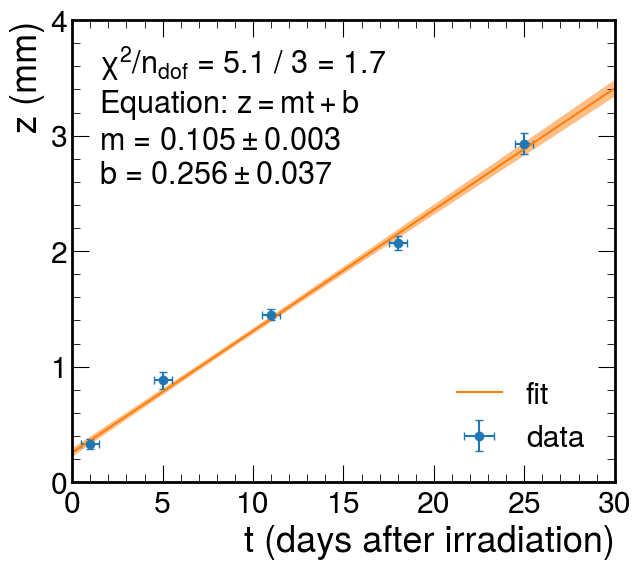

In [155]:
# Fit a line
least_squares = LeastSquares(t, z, ez, line)
m = Minuit(least_squares, m=0.1, b=0.1)
m.migrad()
m.hesse()

# Plot the data and fit
fig, ax = plt.subplots(figsize=(7, 6))
ax.errorbar(t, z, xerr=et, yerr=ez, fmt="o", capsize=3, label="data")
ax.set_xlabel("t (days after irradiation)")
ax.set_ylabel("z (mm)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 4)

# Plotting the fit including the error band
y, ycov = propagate(lambda p: line(t_full, *p), m.values, m.covariance)
yerr_prop = np.diag(ycov) ** 0.5
ax.plot(t_full, y, label="fit")
ax.fill_between(t_full, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)


fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
    "Equation: $z = mt + b$",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")

ax.legend(loc="lower right")
plt.text(1.5, 3.8, "\n".join(fit_info), ha="left", va="top", fontsize=22)

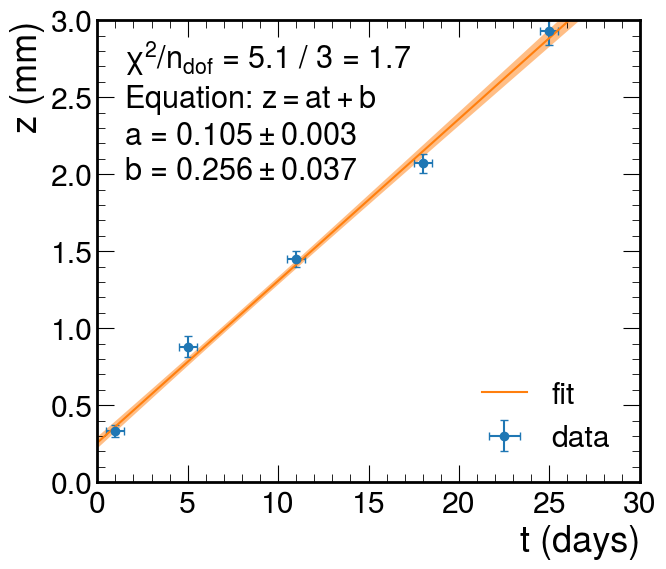

In [69]:
plot_fit_line(t, z, et, ez, is_data=True)

Text(28.8, 0.15, '$\\chi^2$/$n_\\mathrm{dof}$ = 64.7 / 4 = 16.2\nEquation: $z^2 = at$\na = $0.230 \\pm 0.017$')

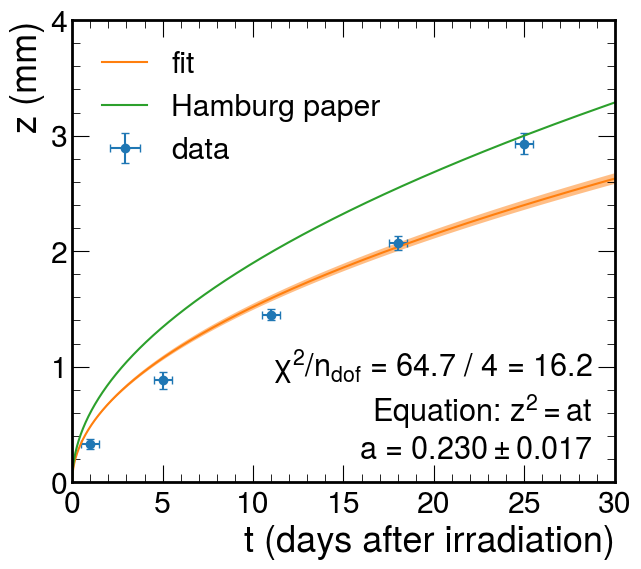

In [158]:
# Fit
least_squares = LeastSquares(t, z, ez, squareroot)
m = Minuit(least_squares, a=0.1)
m.migrad()
m.hesse()

# Plotting the data
fig, ax = plt.subplots(figsize=(7, 6))
ax.errorbar(t, z, xerr=et, yerr=ez, fmt="o", capsize=3, label="data")
ax.set_xlabel("t (days after irradiation)")
ax.set_ylabel("z (mm)")
ax.set_xlim(0, 30)
ax.set_ylim(0, 4)

# Plotting the fit including the error band
y, ycov = propagate(lambda p: squareroot(t_full, p), m.values, m.covariance)
yerr_prop = np.diag(ycov) ** 0.5
ax.plot(t_full, y, label="fit")
ax.fill_between(t_full, y - yerr_prop, y + yerr_prop, facecolor="C1", alpha=0.5)

# Plotting the Hamburg value
ax.plot(t_full, squareroot(t_full, 0.025 * 24), label="Hamburg paper")

# Plotting the fit info and legend
fit_info = [
    f"$\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fval:.1f} / {m.ndof:.0f} = {m.fmin.reduced_chi2:.1f}",
    "Equation: $z^2 = at$",
]
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f"{p} = ${v**2:.3f} \\pm {2*e:.3f}$")

ax.legend()
plt.text(28.8, 0.15, "\n".join(fit_info), ha="right", va="bottom", fontsize=22)

The data from the simulation ($100\times500\times500$ and normal dose rate):

In [41]:
# Initialize the data
t = [
    0,
    80,
    160,
    240,
    320,
    400,
    480,
    560,
    640,
    720,
    800,
    880,
    960,
    1040,
    1120,
    1200,
    1280,
    1360,
    1440,
    1520,
    1600,
    1680,
    1760,
    1840,
    1920,
    2000,
    2080,
    2160,
    2240,
    2320,
    2400,
    2480,
    2560,
    2640,
    2720,
    2800,
    2880,
    2960,
    3040,
    3120,
    3200,
    3280,
    3360,
    3440,
    3520,
    3600,
    3680,
    3760,
    3840,
    3920,
]
z = [
    8,
    9,
    10,
    10,
    11,
    11,
    12,
    13,
    14,
    14,
    15,
    16,
    16,
    17,
    18,
    18,
    19,
    20,
    20,
    21,
    21,
    22,
    23,
    23,
    24,
    24,
    25,
    26,
    26,
    27,
    27,
    28,
    28,
    29,
    30,
    30,
    31,
    31,
    32,
    32,
    33,
    33,
    34,
    34,
    35,
    35,
    36,
    37,
    37,
    38,
]

Try fitting with a straight line

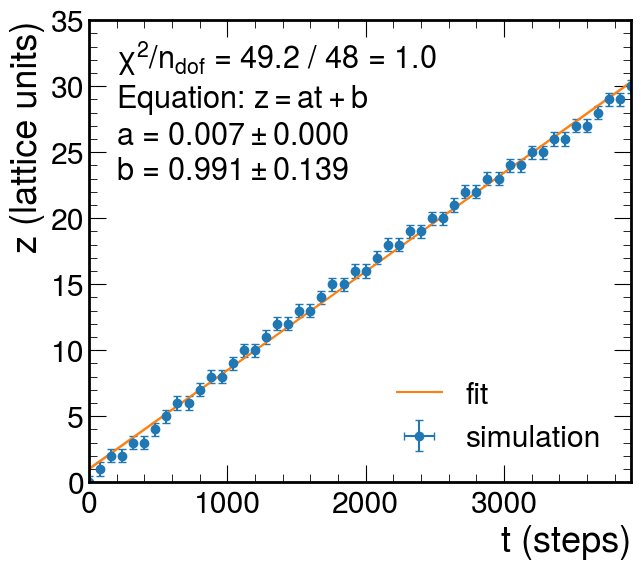

In [51]:
plot_fit_line(t, z)

and then with the square root function (& show the Hamburg fit)

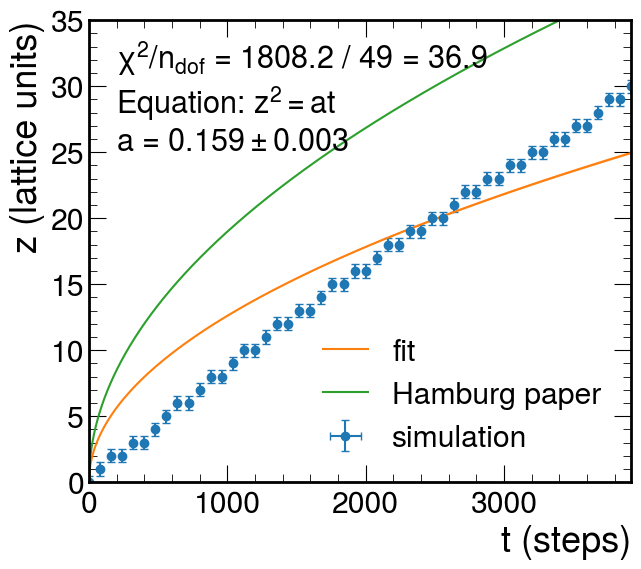

In [52]:
plot_fit_squareroot(t, z, plot_hamburg=True)

Solve the equation without the radicals

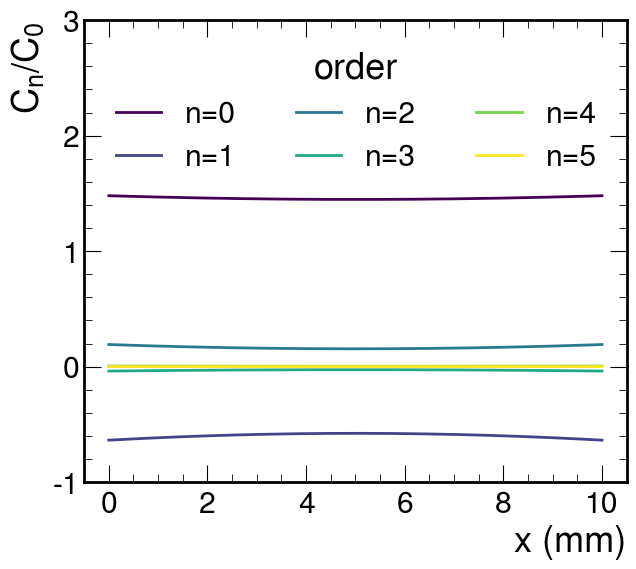

In [165]:
fig, ax = plt.subplots(figsize=(7, 6))
cmap = plt.get_cmap("viridis", 6)

Dt = 100  # mm^2
l = 10  # mm
x = np.linspace(-l / 2, l / 2, 1000)
u_n = lambda n: ((-1) ** n) * erfc(((2 * n + 1) * l / 2 - x) / (2 * np.sqrt(Dt))) + (
    (-1) ** n
) * erfc(((2 * n + 1) * l / 2 + x) / (2 * np.sqrt(Dt)))
for i in range(6):
    ax.plot(x + l / 2, u_n(i), label=f"n={i}", lw=2, color=cmap(i))
plt.xlabel("x (mm)")
plt.ylabel("$C_n/C_0$")
plt.ylim(-1, 3)
plt.legend(title="order", ncol=3)

Text(0, 1, '$C/C_0$')

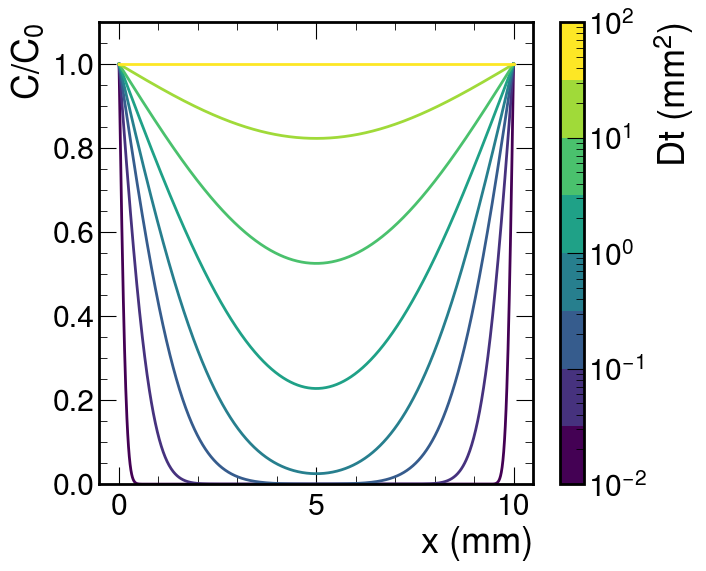

In [174]:
fig, ax = plt.subplots(figsize=(7, 6))
cmap = plt.get_cmap("viridis", 8)

l = 10  # mm
x = np.linspace(-l / 2, l / 2, 1000)
u_n = lambda n, Dt: ((-1) ** n) * erfc(
    ((2 * n + 1) * l / 2 - x) / (2 * np.sqrt(Dt))
) + ((-1) ** n) * erfc(((2 * n + 1) * l / 2 + x) / (2 * np.sqrt(Dt)))
times = [0.01, 0.2, 0.8, 2, 5, 10, 20, 100]
for i, time in enumerate(times):
    u = np.zeros(len(x))
    for n in range(10):
        u += u_n(n, time)
    ax.plot(x + l / 2, u, label=f"{time}", lw=2, color=cmap(i))
plt.ylim(0, 1.1)
norm = colors.LogNorm(vmin=0.01, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Dt (mm$^2$)", orientation="vertical")
# plt.legend(title="Dt (mm$^2$)")
plt.xlabel("x (mm)")
plt.ylabel("$C/C_0$")

/var/folders/4f/rfs4xk8j61x737wyrrknwd980000gn/T/ipykernel_15417/2979223435.py:5: RuntimeWarning: divide by zero encountered in divide
  u_n = lambda n, Dt: ((-1) ** n) * erfc(((2 * n + 1) * l / 2 - x) / (2 * np.sqrt(Dt))) + ((-1) ** n) * erfc(((2 * n + 1) * l / 2 + x) / (2 * np.sqrt(Dt)))
/var/folders/4f/rfs4xk8j61x737wyrrknwd980000gn/T/ipykernel_15417/2979223435.py:5: RuntimeWarning: invalid value encountered in divide
  u_n = lambda n, Dt: ((-1) ** n) * erfc(((2 * n + 1) * l / 2 - x) / (2 * np.sqrt(Dt))) + ((-1) ** n) * erfc(((2 * n + 1) * l / 2 + x) / (2 * np.sqrt(Dt)))


Text(0, 1, '$z_0$ (mm)')

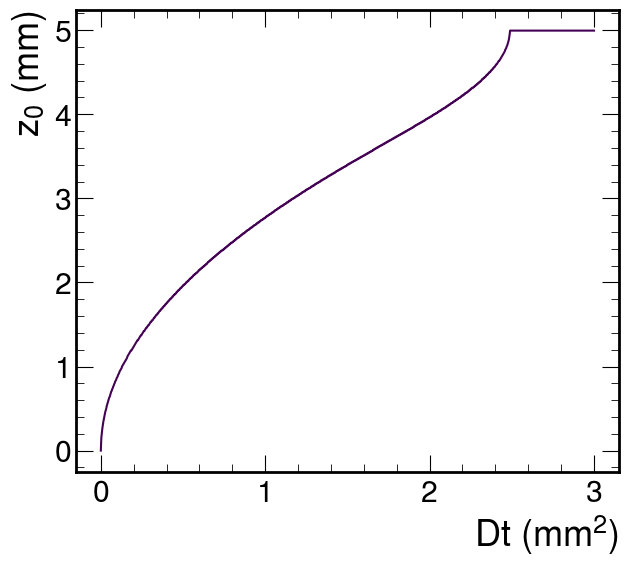

In [175]:
fig, ax = plt.subplots(figsize=(7, 6))

l = 10  # mm
x = np.linspace(-l / 2, l / 2, 1000)
u_n = lambda n, Dt: ((-1) ** n) * erfc(
    ((2 * n + 1) * l / 2 - x) / (2 * np.sqrt(Dt))
) + ((-1) ** n) * erfc(((2 * n + 1) * l / 2 + x) / (2 * np.sqrt(Dt)))
times = np.linspace(0, 3, 1000)
z_0p05 = np.array([])
for time in times:
    u = np.zeros(len(x))
    for n in range(10):
        u += u_n(n, time)
    diff = np.abs(u[x < 0] - 0.05)
    z_0p05 = np.append(z_0p05, x[np.argmin(diff)] + l / 2)
ax.plot(times, z_0p05)
plt.xlabel("Dt (mm$^2$)")
plt.ylabel("$z_0$ (mm)")

Text(0, 1, '$z_0$ (mm)')

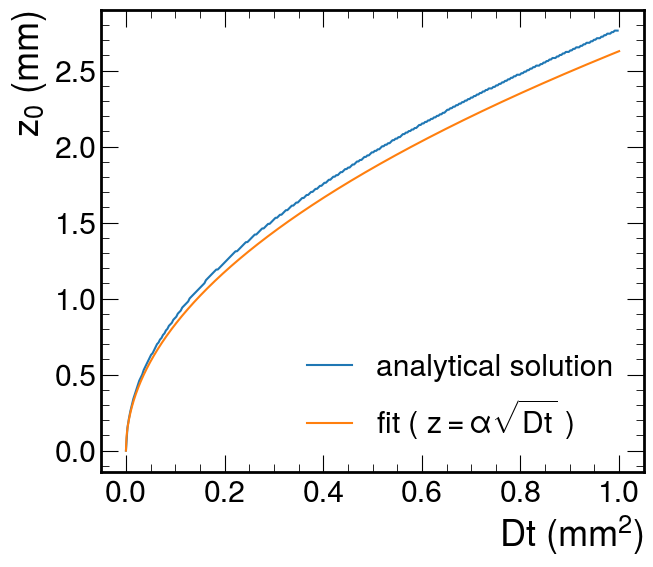

In [146]:
times_truncated = times[times < 1]
z_truncated = z_0p05[times < 1]
ez_truncated = z_truncated * 0.05

# Fit
least_squares = LeastSquares(times_truncated, z_truncated, ez_truncated, squareroot)
m = Minuit(least_squares, a=0.1)
m.migrad()
m.hesse()

# Plotting the data
fig, ax = plt.subplots(figsize=(7, 6))
ax.plot(times_truncated, z_truncated, label="analytical solution")

# Plotting the fit including the error band
t_full = np.linspace(0, 1, 1000)
ax.plot(t_full, y, label="fit ( $z = \\alpha\\sqrt{Dt}$ )")
ax.legend()
ax.set_xlabel("Dt (mm$^2$)")
ax.set_ylabel("$z_0$ (mm)")

Bellow is the plot for the $1000 \times 1000 \times 50$ lattice. Dose rate is high (10x)

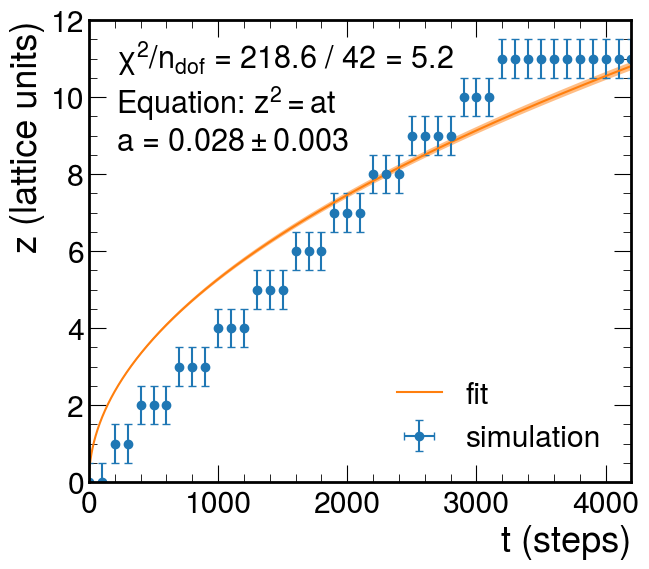

In [40]:
t = [
    0,
    100,
    200,
    300,
    400,
    500,
    600,
    700,
    800,
    900,
    1000,
    1100,
    1200,
    1300,
    1400,
    1500,
    1600,
    1700,
    1800,
    1900,
    2000,
    2100,
    2200,
    2300,
    2400,
    2500,
    2600,
    2700,
    2800,
    2900,
    3000,
    3100,
    3200,
    3300,
    3400,
    3500,
    3600,
    3700,
    3800,
    3900,
    4000,
    4100,
    4200,
]
z = [
    13,
    13,
    14,
    14,
    15,
    15,
    15,
    16,
    16,
    16,
    17,
    17,
    17,
    18,
    18,
    18,
    19,
    19,
    19,
    20,
    20,
    20,
    21,
    21,
    21,
    22,
    22,
    22,
    22,
    23,
    23,
    23,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
]
plot_fit_squareroot(t, z)

This is the high dose rate (x10) case with the old lattice: $500\times 500\times 50$

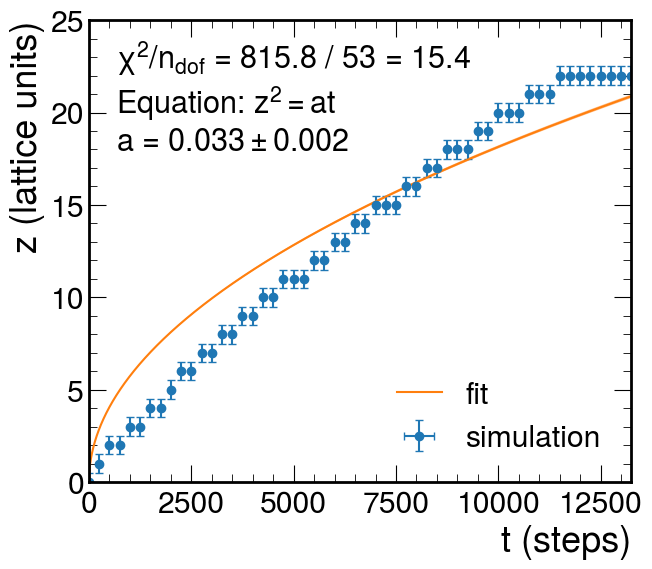

In [39]:
t = [
    0,
    250,
    500,
    750,
    1000,
    1250,
    1500,
    1750,
    2000,
    2250,
    2500,
    2750,
    3000,
    3250,
    3500,
    3750,
    4000,
    4250,
    4500,
    4750,
    5000,
    5250,
    5500,
    5750,
    6000,
    6250,
    6500,
    6750,
    7000,
    7250,
    7500,
    7750,
    8000,
    8250,
    8500,
    8750,
    9000,
    9250,
    9500,
    9750,
    10000,
    10250,
    10500,
    10750,
    11000,
    11250,
    11500,
    11750,
    12000,
    12250,
    12500,
    12750,
    13000,
    13250,
]
z = [
    2,
    3,
    4,
    4,
    5,
    5,
    6,
    6,
    7,
    8,
    8,
    9,
    9,
    10,
    10,
    11,
    11,
    12,
    12,
    13,
    13,
    13,
    14,
    14,
    15,
    15,
    16,
    16,
    17,
    17,
    17,
    18,
    18,
    19,
    19,
    20,
    20,
    20,
    21,
    21,
    22,
    22,
    22,
    23,
    23,
    23,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
    24,
]
plot_fit_squareroot(t, z)

No irradiation case. Lattice 500x500x50.

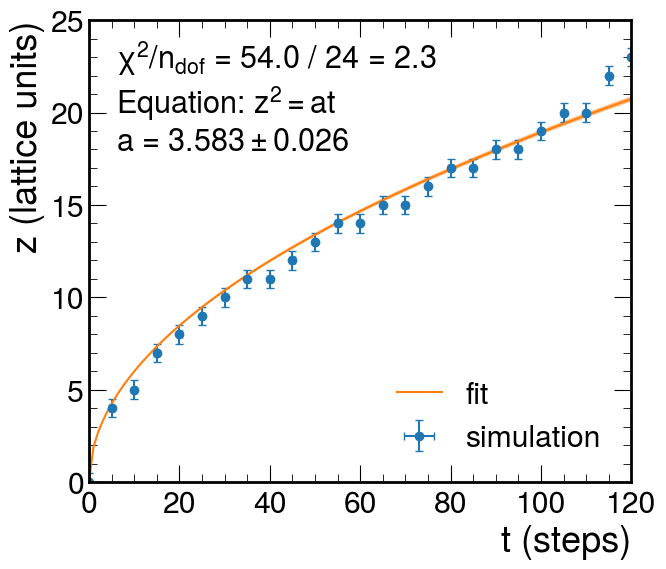

In [38]:
t = [
    0,
    5,
    10,
    15,
    20,
    25,
    30,
    35,
    40,
    45,
    50,
    55,
    60,
    65,
    70,
    75,
    80,
    85,
    90,
    95,
    100,
    105,
    110,
    115,
    120,
]
z = [
    1,
    5,
    6,
    8,
    9,
    10,
    11,
    12,
    12,
    13,
    14,
    15,
    15,
    16,
    16,
    17,
    18,
    18,
    19,
    19,
    20,
    21,
    21,
    23,
    24,
]
plot_fit_squareroot(t, z)

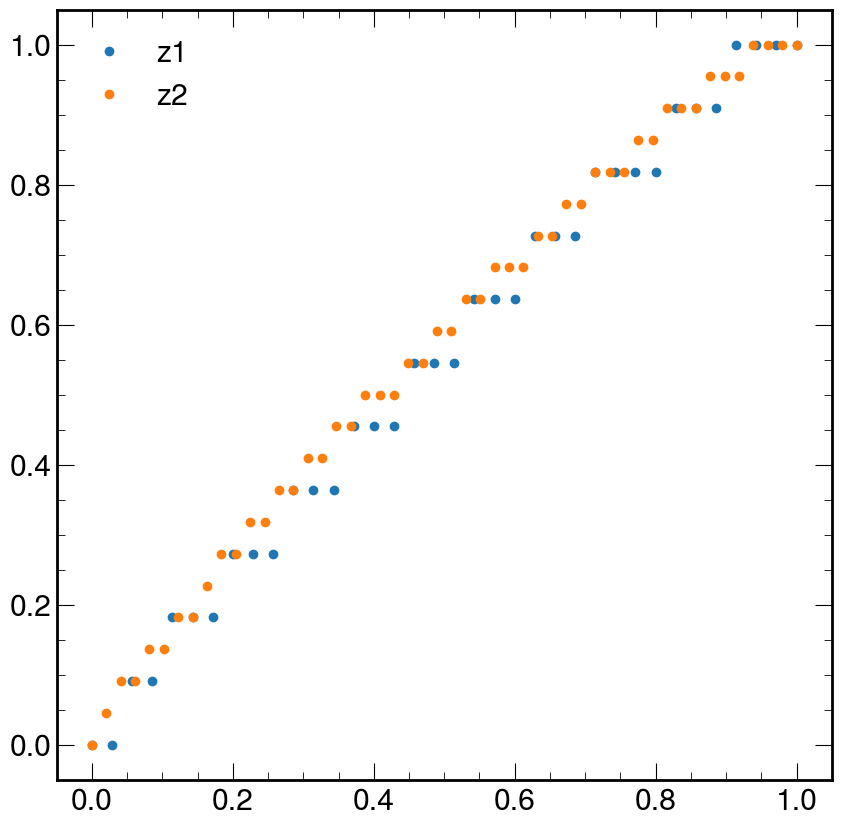

In [14]:
t1 = np.array(
    [
        0,
        100,
        200,
        300,
        400,
        500,
        600,
        700,
        800,
        900,
        1000,
        1100,
        1200,
        1300,
        1400,
        1500,
        1600,
        1700,
        1800,
        1900,
        2000,
        2100,
        2200,
        2300,
        2400,
        2500,
        2600,
        2700,
        2800,
        2900,
        3000,
        3100,
        3200,
        3300,
        3400,
        3500,
        3600,
        3700,
        3800,
        3900,
        4000,
        4100,
        4200,
    ]
)
z1 = np.array(
    [
        13,
        13,
        14,
        14,
        15,
        15,
        15,
        16,
        16,
        16,
        17,
        17,
        17,
        18,
        18,
        18,
        19,
        19,
        19,
        20,
        20,
        20,
        21,
        21,
        21,
        22,
        22,
        22,
        22,
        23,
        23,
        23,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
    ]
)
t2 = np.array(
    [
        0,
        250,
        500,
        750,
        1000,
        1250,
        1500,
        1750,
        2000,
        2250,
        2500,
        2750,
        3000,
        3250,
        3500,
        3750,
        4000,
        4250,
        4500,
        4750,
        5000,
        5250,
        5500,
        5750,
        6000,
        6250,
        6500,
        6750,
        7000,
        7250,
        7500,
        7750,
        8000,
        8250,
        8500,
        8750,
        9000,
        9250,
        9500,
        9750,
        10000,
        10250,
        10500,
        10750,
        11000,
        11250,
        11500,
        11750,
        12000,
        12250,
        12500,
        12750,
        13000,
        13250,
    ]
)
z2 = np.array(
    [
        2,
        3,
        4,
        4,
        5,
        5,
        6,
        6,
        7,
        8,
        8,
        9,
        9,
        10,
        10,
        11,
        11,
        12,
        12,
        13,
        13,
        13,
        14,
        14,
        15,
        15,
        16,
        16,
        17,
        17,
        17,
        18,
        18,
        19,
        19,
        20,
        20,
        20,
        21,
        21,
        22,
        22,
        22,
        23,
        23,
        23,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
        24,
    ]
)

cutoff1 = -7
cutoff2 = -4
t1 = t1[:cutoff1]
t2 = t2[:cutoff2]
z1 = z1[:cutoff1]
z2 = z2[:cutoff2]

t1 = t1 - t1[0]
t2 = t2 - t2[0]
z1 = z1 - z1[0]
z2 = z2 - z2[0]

t1 = t1 / t1[-1]
t2 = t2 / t2[-1]
z1 = z1 / z1[-1]
z2 = z2 / z2[-1]

plt.plot(t1, z1, "o", label="z1")
plt.plot(t2, z2, "o", label="z2")
plt.legend()